# Residual model generation pipeline

In [24]:
import os
import torch
import shutil
import numpy as np
import matplotlib.pyplot as plt

import LMCE.cfusdlog as cfusdlog
from LMCE.model import MLP
from LMCE.residual_calculation import brushless_residual
from LMCE.data_prep import prepare_data, create_dataloader
from LMCE.model_to_c_conversion import exportNet, c_model_test

## Preparing the data
First define where the data is stored, then it can be loaded, the `prepare_data` function calculates the labels (residual forces).

In [25]:
data_path = "./crazyflie-data-collection"

# Get train data paths
indices = [f"{i:02}" for i in range(0, 86)]
test_indices = [24]
for i in test_indices:
    del indices[i]
training_data_paths = [f"./crazyflie-data-collection/brushless_flights_payload/data/eckart{i}" for i in indices]
testing_data_paths = [f"./crazyflie-data-collection/brushless_flights_payload/data/eckart{i}" for i in test_indices]

# Prepare data
X_train, y_train = prepare_data(training_data_paths, save_as="train_data_brushless", residual_func=brushless_residual)
X_test, y_test = prepare_data(testing_data_paths, save_as="test_data_brushless", shuffle_data=False, residual_func=brushless_residual)
train_dataloader = create_dataloader(X_train, y_train)
test_dataloader = create_dataloader(X_test, y_test)

Data already exists, loading from files...
Data already exists, loading from files...


We can plot the flight path and residual forces like this

eckart24 mean residual f_x: -0.0006137759017934554
eckart24 mean residual f_y: 0.006224058597616975
eckart24 mean residual f_z: -0.06903529803280554


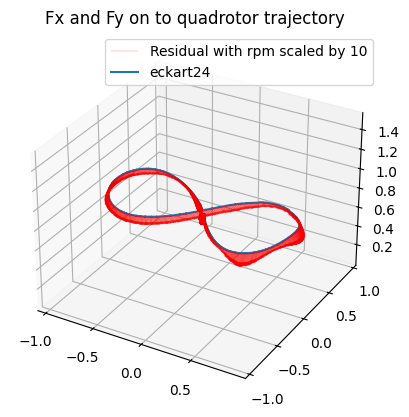

In [26]:
data_path = testing_data_paths[0]
visual_scale = 1.

fig = plt.figure()
ax = plt.axes(projection='3d')

data = cfusdlog.decode(data_path)['fixedFrequency']
label = os.path.basename(data_path)

x = [i for i in data["stateEstimate.x"]]
y = [i for i in data["stateEstimate.y"]]
z = [i for i in data["stateEstimate.z"]]
origin = np.array([x, y, z]).T

f, _ = brushless_residual(data, use_rpm=True)
vector = np.array([f[:, 0], f[:, 1], f[:, 2]]).T * visual_scale
ax.quiver(origin[:, 0], origin[:, 1], origin[:, 2], vector[:, 0], vector[:, 1], vector[:, 2], color='r', alpha=.1, label="Residual with rpm scaled by 10")

ax.plot3D(x, y, z, label=label)

# Calculate the avg. residual force for each axis
for j, v in enumerate(["x", "y", "z"]):
    f_j = [f_[j] for f_ in f]
    print(f"{label} mean residual f_{v}: {sum(f_j)/len(f_j)}")

plt.title("Fx and Fy on to quadrotor trajectory")
plt.legend()
plt.axis('equal')
plt.show()

## Training the model

Epoch 1
-------------------------------
avg. train loss:  0.016911
Avg. test loss: 0.000083 


-------------------------------
Epoch 2
-------------------------------
avg. train loss:  0.000301
Avg. test loss: 0.000067 


-------------------------------
Epoch 3
-------------------------------
avg. train loss:  0.000096
Avg. test loss: 0.000016 


-------------------------------
Epoch 4
-------------------------------
avg. train loss:  0.000053
Avg. test loss: 0.000016 


-------------------------------
Epoch 5
-------------------------------
avg. train loss:  0.000037
Avg. test loss: 0.000007 


-------------------------------
Epoch 6
-------------------------------
avg. train loss:  0.000032
Avg. test loss: 0.000009 


-------------------------------
Epoch 7
-------------------------------
avg. train loss:  0.000030
Avg. test loss: 0.000004 


-------------------------------
Epoch 8
-------------------------------
avg. train loss:  0.000027
Avg. test loss: 0.000004 


----------------

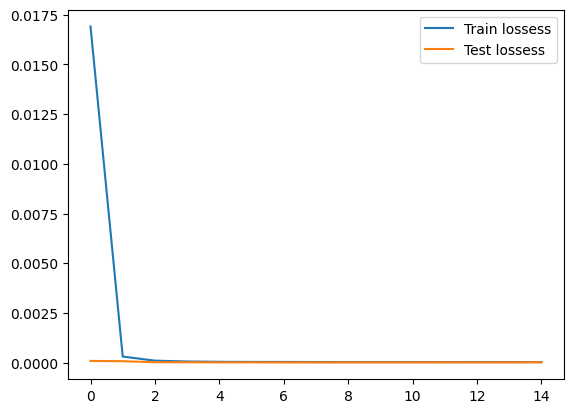

In [27]:
# Create and train neural network
model = MLP()
model.train_model(train_dataloader, test_dataloader, epochs=20)
model.show_progress()
model.save("model.pth")

## Testing the model

Average error: (x) -> 0.0036222096341308376 (y) -> 0.0027422944406327314


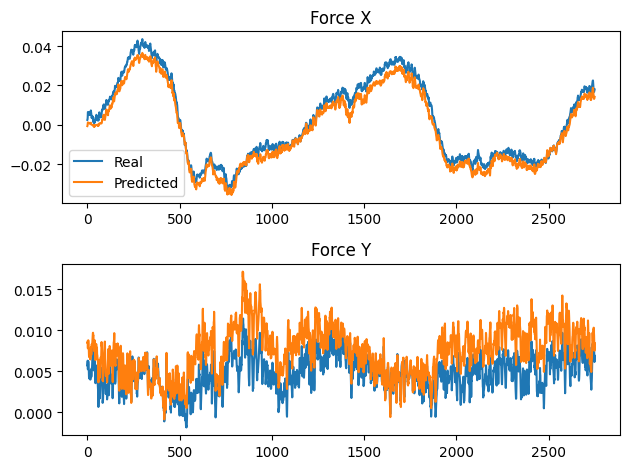

In [28]:
weights = torch.load('./models/model.pth')
model.load_state_dict(weights)

tensor_input = torch.from_numpy(X_test)
pred = model.forward(tensor_input).detach().numpy()
error = np.abs(y_test-pred)
print(f"Average error: (x) -> {np.mean(error[:, 0])} (y) -> {np.mean(error[:, 1])}")

fig, ax = plt.subplots(2)
ax[0].plot(y_test[:, 0], label="Real")
ax[0].plot(pred[:, 0], label="Predicted")
ax[0].set_title('Force X')

ax[1].plot(y_test[:, 1], label="Real")
ax[1].plot(pred[:, 1], label="Predicted")
ax[1].set_title('Force Y')

ax[0].legend()
plt.tight_layout()
plt.show()

## Translating the model to c code

In [29]:
# Generate the model c code
model_path = "./models/model.pth"
exportNet(model_path)

# Test if the generated model gives the same outputs as the original
c_model_test(model, "./data/test_data.npz")

Comparing with original...
Models give the same outputs!


## Adding the model to the cf-firmware

In [30]:
shutil.copyfile("./LMCE/c_utils/nn.c", "./crazyflie-firmware/src/modules/src/controller/nn.c")
shutil.copyfile("./LMCE/c_utils/nn.h", "./crazyflie-firmware/src/modules/interface/controller/nn.h")

'./crazyflie-firmware/src/modules/interface/controller/nn.h'